In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn import preprocessing, metrics
import gc
import os
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from workalendar.usa.texas import Texas
from workalendar.usa.california import California
from workalendar.usa.wisconsin import Wisconsin

from scipy import stats

from sklearn.preprocessing import scale
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [2]:
! pip install tslearn 
#Special tools for timeseries:
from tslearn.clustering import KShape
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
%matplotlib inline

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


# function to read the data and merge it (ignoring some columns, this is a very fst model)


def read_data():
    print('Reading files...')
    calendar = pd.read_csv('../input/calendar.csv')
    calendar = reduce_mem_usage(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    sell_prices = pd.read_csv('../input/sell_prices.csv')
    sell_prices = reduce_mem_usage(sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    sales_train_validation = pd.read_csv('../input/sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    submission = pd.read_csv('../input/sample_submission.csv')
    sales_train_evaluation = pd.read_csv("../input/sales_train_evaluation.csv")
    print('Sales train evaluation has {} rows and {} columns'.format(sales_train_evaluation.shape[0], sales_train_evaluation.shape[1]))
    return calendar, sell_prices, sales_train_validation, submission,sales_train_evaluation

In [4]:
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 
        
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [5]:
## Merging by concat to not lose dtypes
def merge_by_concat(df1, df2, merge_on):
    merged_gf = df1[merge_on]
    merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
    new_columns = [col for col in list(merged_gf) if col not in merge_on]
    df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
    return df1

In [6]:
def melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 55000000, merge = False):
    
    # melt sales data, get it ready for training
    sales_train_validation = pd.melt(sales_train_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    print('Melted sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    sales_train_validation = reduce_mem_usage(sales_train_validation)
    
    
    # seperate test dataframes
    test1_rows = [row for row in submission['id'] if 'validation' in row]
    test2_rows = [row for row in submission['id'] if 'evaluation' in row]
    test1 = submission[submission['id'].isin(test1_rows)]
    test2 = submission[submission['id'].isin(test2_rows)]
    
    # change column names
    test1.columns = ['id', 'd_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921', 'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930', 'd_1931', 
                      'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939', 'd_1940', 'd_1941']
    test2.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959', 
                      'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']
    
    # get product table
    product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
    
    # merge with product table
    test2['id'] = test2['id'].str.replace('_evaluation','_validation')
    test1 = test1.merge(product, how = 'left', on = 'id')
    #test2がこれから予測して提出するデータ
    test2 = test2.merge(product, how = 'left', on = 'id')
    test2['id'] = test2['id'].str.replace('_validation','_evaluation')
    
    # 
    test1 = pd.melt(test1, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    test2 = pd.melt(test2, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    
    sales_train_validation['part'] = 'train'
    test1['part'] = 'test1'
    test2['part'] = 'test2'
    
    data = pd.concat([sales_train_validation, test1, test2], axis = 0)
    
    del sales_train_validation, test1, test2
    
    # get only a sample for fst training
    data = data.loc[nrows:]
    
    # drop some calendar features
    calendar.drop(['weekday', 'wday', 'month', 'year'], inplace = True, axis = 1)
    
    # delete test2 for now
    data = data[data['part'] != 'test2']
    
    if merge:
        # notebook crash with the entire dataset (maybee use tensorflow, dask, pyspark xD)
        data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
        data.drop(['d'], inplace = True, axis = 1)
        # get the sell price data (this feature should be very important)
        data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
        print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))
    else: 
        pass
    
    gc.collect()
    
    return data

In [7]:
calendar, sell_prices, sales_train_validation, submission, sales_train_evaluation = read_data()

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns
Sales train evaluation has 30490 rows and 1947 columns


In [8]:
data = melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 27500000, merge = True)

Melted sales train validation has 58327370 rows and 8 columns
Mem. usage decreased to 3226.27 Mb (9.4% reduction)
Our final dataset to train has 31681090 rows and 19 columns


In [9]:
data.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOUSEHOLD_1_514_WI_3_validation,HOUSEHOLD_1_514,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,16,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,3.500000
1,HOUSEHOLD_1_515_WI_3_validation,HOUSEHOLD_1_515,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,2.470703
2,HOUSEHOLD_1_516_WI_3_validation,HOUSEHOLD_1_516,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,1.980469
3,HOUSEHOLD_1_517_WI_3_validation,HOUSEHOLD_1_517,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,0.979980
4,HOUSEHOLD_1_518_WI_3_validation,HOUSEHOLD_1_518,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,0,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,NaN


In [10]:
first_sell_df = data[data.demand > 0]

first_sell_df = first_sell_df.groupby(['item_id','store_id'])['wm_yr_wk'].min().reset_index()
first_sell_df.columns = ['item_id', 'store_id', 'release']

data = pd.merge(data, first_sell_df, on=['item_id','store_id'], how='left')
data.release = data.release.fillna(0).astype(np.int16)
del first_sell_df
gc.collect()

0

In [11]:
data.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,release
0,HOUSEHOLD_1_514_WI_3_validation,HOUSEHOLD_1_514,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,16,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,3.500000,11325
1,HOUSEHOLD_1_515_WI_3_validation,HOUSEHOLD_1_515,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,2.470703,11325
2,HOUSEHOLD_1_516_WI_3_validation,HOUSEHOLD_1_516,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,1.980469,11325
3,HOUSEHOLD_1_517_WI_3_validation,HOUSEHOLD_1_517,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,0.979980,11325
4,HOUSEHOLD_1_518_WI_3_validation,HOUSEHOLD_1_518,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,0,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,NaN,11353


In [12]:
%%time

# Let's check again memory usage
print("{:>20}: {:>8}".format('Original grid_df',sizeof_fmt(data.memory_usage(index=True).sum())))

data = data[data.wm_yr_wk >= data.release] 
data['cum_day'] = data['day'].apply(lambda x:x[2:]).astype(np.int16)

gc.collect()


# Let's check again memory usage
print("{:>20}: {:>8}".format('Reduced grid_df',sizeof_fmt(data.memory_usage(index=True).sum())))

    Original grid_df:   3.8GiB
     Reduced grid_df:   3.6GiB
CPU times: user 17.1 s, sys: 8.39 s, total: 25.5 s
Wall time: 25.4 s


In [13]:
data.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,release,cum_day
0,HOUSEHOLD_1_514_WI_3_validation,HOUSEHOLD_1_514,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,16,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,3.500000,11325,902
1,HOUSEHOLD_1_515_WI_3_validation,HOUSEHOLD_1_515,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,2.470703,11325,902
2,HOUSEHOLD_1_516_WI_3_validation,HOUSEHOLD_1_516,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,1.980469,11325,902
3,HOUSEHOLD_1_517_WI_3_validation,HOUSEHOLD_1_517,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,0.979980,11325,902
6,HOUSEHOLD_1_520_WI_3_validation,HOUSEHOLD_1_520,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,d_902,1,train,2013-07-18,11325,NaN,NaN,NaN,NaN,0,0,0,5.480469,11325,902


In [14]:
cols = ['id','item_id','dept_id','cat_id','store_id','state_id','cum_day','demand','release','wm_yr_wk']
grid_df = data[cols]
grid_df.columns = ['id','item_id','dept_id','cat_id','store_id','state_id','d','sales','release','wm_yr_wk']
del data ;gc.collect()

40

In [15]:
def gap_finder(ts):
    
    # this function finds gaps and calculates their length:
    # note ts: 0 = day with sales, 1 = days with 0 sales
    
    for i, gap in enumerate(ts):
        if gap == 0: 
            continue
        elif i!=0: 
            ts[i] += ts[i-1]
            if ts[i-1]!=0: ts[i-1] = -1
    return ts

In [16]:
# Note: in 'gap' column: 1 is a day without sales:
grid_df['gaps'] = (~(grid_df['sales'] > 0)).astype(int)
total_days = 1941

prods = list(grid_df.id.unique())
s_list = [] #list to hold gaps in days
e_list = [] #list to hold expected values of gaps
p_list = [] #list to hold avg probability of no sales

# magic x8 speed booster thanks to @nadare
for prod_id, df in tqdm_notebook(grid_df.groupby("id")):   
    # extract gap_series for a prod_id
    sales_gaps = df.loc[:,'gaps']

    # calculate initial probability
    zero_days = sum(sales_gaps)
    p = zero_days/total_days

    # find and mark gaps
    accum_add_prod = np.frompyfunc(lambda x, y: int((x+y)*y), 2, 1)
    sales_gaps[:] = accum_add_prod.accumulate(df["gaps"], dtype=np.object).astype(int)
    sales_gaps[sales_gaps < sales_gaps.shift(-1)] = np.NaN
    sales_gaps = sales_gaps.fillna(method="bfill").fillna(method='ffill')
    s_list += [sales_gaps]
    
    # calculate E/total_days for all possible gap lengths:
    gap_length = sales_gaps.unique()
    
    d = {length: ((1-p**length)/(p**length*(1-p)))/365 for length in gap_length}
    sales_E_years = sales_gaps.map(d)
    
    # cut out supply_gap days and run recursively
    p1 = 0
    while p1 < p:
        
        if p1!=0:
            p=p1
        
        # once in 100 years event; change to your taste here
        gap_days = sum(sales_E_years>100)
            
        p1 = (zero_days-gap_days+0.0001)/(total_days-gap_days)
        
        d = {length: ((1-p1**length)/(p1**length*(1-p1)))/365 for length in gap_length}
        sales_E_years = sales_gaps.map(d)
        
    # add results to list it turns out masked replacemnt is a very expensive operation in pandas, so better do it in one go
    e_list += [sales_E_years]
    p_list += [pd.Series(p,index=sales_gaps.index)]

In [17]:
grid_df = reduce_mem_usage(grid_df)

Mem. usage decreased to 1820.79 Mb (16.7% reduction)


In [18]:
# add it to grid_df in one go fast!:
grid_df['gap_days'] = pd.concat(s_list)
grid_df['gap_e'] = pd.concat(e_list)
grid_df['sale_prob'] = pd.concat(p_list)
##45664
# Dump to pickle:
# grid_df.to_pickle('grid_part_1_gaps.pkl')

In [19]:
# I use 100 years as threshold for a stockout. If you feel it is too much, lower it.
years_threshold = 90
grid_df.loc[:,'stockout'] = (grid_df.gap_e >= years_threshold)*1

# Find outliers based on z score:
## Filter out values more than 0 as otherwise all sales might be flagged as outliers:
mask = grid_df.sales > 0

## Group by 'id' as sales values have diffrenet mean from store to store: 
df_grouped = grid_df[mask].groupby(['id'])

## Find indices of all outliers:
outlier_idx = []
for group_name, g in tqdm_notebook(df_grouped):
    outlier_idx += list(g[stats.zscore(g.sales) > 3].index) 
    
## Create separate column with outliers: zeroes by default & sales values for outliers values.
grid_df.loc[:,'sale_outlier'] = 0
grid_df.loc[outlier_idx,'sale_outlier'] = grid_df.loc[outlier_idx,'sales']

In [20]:
grid_df = reduce_mem_usage(grid_df)
# Cap sales outliers with maximum non outlier value:
grid_df['sales_clean'] = grid_df['sales']
nan_idx = grid_df[~grid_df.sales.isna()].index
grid_df.loc[outlier_idx,'sales_clean'] = np.nan

grid_df.loc[nan_idx,'sales_clean'] = grid_df.loc[nan_idx,'sales_clean'].fillna(grid_df.groupby('id',sort=False)['sales_clean'].transform('max'))

Mem. usage decreased to 3520.97 Mb (16.6% reduction)


In [21]:
mask = grid_df.stockout>0
grid_df.loc[mask,'sales_clean'] = np.nan

# Group by id:
df_grouped = grid_df.groupby("id",sort=False)["sales_clean"]

# Generate rolling mean to fill in stockouts:
lag = 1
w = 7
col_name = f"rolling_w{str(w)}_l{str(lag)}_mean"
grid_df[col_name] = df_grouped.transform(lambda x: x.shift(lag).rolling(w, min_periods=w).mean()).astype(np.float32)
grid_df[col_name] = grid_df[col_name].fillna(method='ffill')

# Fill in stockouts: 
grid_df.loc[mask, 'sales_clean'] = grid_df.loc[mask, col_name]

In [22]:
grid_df.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,wm_yr_wk,gaps,gap_days,gap_e,sale_prob,stockout,sale_outlier,sales_clean,rolling_w7_l1_mean
0,HOUSEHOLD_1_514_WI_3_validation,HOUSEHOLD_1_514,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,902,16,11325,11325,0,0.0,0.000000e+00,0.011513,0,0,16.0,NaN
1,HOUSEHOLD_1_515_WI_3_validation,HOUSEHOLD_1_515,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,902,1,11325,11325,0,0.0,0.000000e+00,0.182983,0,0,1.0,NaN
2,HOUSEHOLD_1_516_WI_3_validation,HOUSEHOLD_1_516,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,902,1,11325,11325,0,0.0,0.000000e+00,0.080627,0,0,1.0,NaN
3,HOUSEHOLD_1_517_WI_3_validation,HOUSEHOLD_1_517,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,902,1,11325,11325,0,0.0,0.000000e+00,0.043671,0,0,1.0,NaN
6,HOUSEHOLD_1_520_WI_3_validation,HOUSEHOLD_1_520,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,902,1,11325,11325,0,40.0,1.168386e+24,0.217285,1,0,NaN,NaN


In [23]:
grid_df.tail(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,wm_yr_wk,gaps,gap_days,gap_e,sale_prob,stockout,sale_outlier,sales_clean,rolling_w7_l1_mean
31681085,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1941,0,11341,11617,1,28.0,1.902887e+17,0.197144,1,0,0.857143,0.857143
31681086,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1941,0,11325,11617,1,29.0,1.154540e+27,0.095520,1,0,0.857143,0.857143
31681087,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1941,0,11325,11617,1,29.0,6.857942e+20,0.156982,1,0,0.857143,0.857143
31681088,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1941,0,11331,11617,1,28.0,8.217696e+20,0.145874,1,0,0.857143,0.857143
31681089,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1941,0,11405,11617,1,43.0,9.460450e+39,0.102783,1,0,0.857143,0.857143


In [24]:
# Create week-porduct_id aggregations:
week_df = grid_df[['item_id','wm_yr_wk','sales_clean']].groupby(['item_id','wm_yr_wk'], sort=False).mean().fillna(0).astype(np.float32).reset_index()
# Note we add 1 so that zeroes map to zeroes and small values map to small values.
week_df.loc[:, 'sales_clean'] = np.log(week_df.sales_clean+1)

In [25]:
week_df.tail(5)

,item_id,wm_yr_wk,sales_clean
437835,FOODS_3_823,11617,0.619039
437836,FOODS_3_824,11617,0.619039
437837,FOODS_3_825,11617,0.619039
437838,FOODS_3_826,11617,0.619039
437839,FOODS_3_827,11617,0.619039


In [26]:
sorted_df = week_df.sort_values('wm_yr_wk')
sorted_df.wm_yr_wk.unique()

array([11325, 11326, 11327, 11328, 11329, 11330, 11331, 11332, 11333,
       11334, 11335, 11336, 11337, 11338, 11339, 11340, 11341, 11342,
       11343, 11344, 11345, 11346, 11347, 11348, 11349, 11350, 11351,
       11352, 11353, 11401, 11402, 11403, 11404, 11405, 11406, 11407,
       11408, 11409, 11410, 11411, 11412, 11413, 11414, 11415, 11416,
       11417, 11418, 11419, 11420, 11421, 11422, 11423, 11424, 11425,
       11426, 11427, 11428, 11429, 11430, 11431, 11432, 11433, 11434,
       11435, 11436, 11437, 11438, 11439, 11440, 11441, 11442, 11443,
       11444, 11445, 11446, 11447, 11448, 11449, 11450, 11451, 11452,
       11501, 11502, 11503, 11504, 11505, 11506, 11507, 11508, 11509,
       11510, 11511, 11512, 11513, 11514, 11515, 11516, 11517, 11518,
       11519, 11520, 11521, 11522, 11523, 11524, 11525, 11526, 11527,
       11528, 11529, 11530, 11531, 11532, 11533, 11534, 11535, 11536,
       11537, 11538, 11539, 11540, 11541, 11542, 11543, 11544, 11545,
       11546, 11547,

In [27]:
# Please, note that this is implementation is one-way there is no way to go back to unscaled version.
# However, we only use the target for clusterization not prediction here.
week_df['sales_clean'] = week_df.groupby('item_id').sales_clean.transform(lambda x: scale(x.astype(float)))
week_df.tail()

,item_id,wm_yr_wk,sales_clean
437835,FOODS_3_823,11617,-1.314152
437836,FOODS_3_824,11617,-1.085434
437837,FOODS_3_825,11617,-1.050237
437838,FOODS_3_826,11617,-1.747396
437839,FOODS_3_827,11617,-2.375376


In [28]:
week_df.describe()

,wm_yr_wk,sales_clean
count,437840.000000,4.378400e+05
mean,11469.434444,3.021018e-08
std,84.881977,9.999179e-01
min,11325.000000,-7.246130e+00
25%,11413.000000,-6.468430e-01
50%,11450.000000,-5.402905e-02
75%,11534.000000,5.919250e-01
max,11617.000000,9.892440e+00


In [29]:
week_df.wm_yr_wk -=11325

In [30]:
nc = 9
start_week = 180
end_week = 288
seed = 100

week_mask = (week_df.wm_yr_wk>start_week) & (week_df.wm_yr_wk < end_week)

X_train = week_df.loc[week_mask,['item_id','sales_clean','wm_yr_wk']].pivot(columns='item_id', index='wm_yr_wk').T
X_train.head(5)


wm_yr_wk                      181       182       183       184       185  \
            item_id                                                         
sales_clean FOODS_1_001 -1.335463  0.578415 -1.231902 -0.670824 -0.292331   
            FOODS_1_002  0.398576 -0.188211 -0.383816  0.415442  0.228701   
            FOODS_1_003 -0.856313 -1.409526 -0.215108 -1.362372 -1.745246   
            FOODS_1_004  0.063043  0.557812  0.593571  0.956586  0.967907   
            FOODS_1_005  0.321469  0.352958  0.798465  0.594643  2.060515   

wm_yr_wk                      186       187       188       189       190  \
            item_id                                                         
sales_clean FOODS_1_001 -0.940709 -0.432385 -0.866288 -0.097623 -0.965655   
            FOODS_1_002 -0.820998 -0.259004 -0.491753  0.125708 -0.913941   
            FOODS_1_003  0.979936 -1.892246  1.417219  0.064702 -0.444070   
            FOODS_1_004  1.082317 -1.321536  0.726542  1.238391  1.264862   
            FOODS_1_005  2.857454  0.264074 -1.152519 -0.893546 -0.683754   

wm_yr_wk                      191       192       193       194       195  \
            item_id                                                         
sales_clean FOODS_1_001 -0.841619 -0.292331 -0.891025  0.115065  0.103997   
            FOODS_1_002 -0.618812 -1.045178  0.039260 -0.276761 -0.082735   
            FOODS_1_003 -0.560322 -1.378068 -0.707345 -0.886345 -1.536242   
            FOODS_1_004  1.027009  0.995875  1.145995  0.916341  1.036056   
            FOODS_1_005  0.560419  1.008811  0.007516 -0.472789 -1.058425   

wm_yr_wk                      196       197       198       199       200  \
            item_id                                                         
sales_clean FOODS_1_001 -0.755812 -0.269202 -0.538892 -0.269202 -0.200173   
            FOODS_1_002 -0.401743 -0.582383  0.073908 -1.177741 -0.509829   
            FOODS_1_003  0.147308 -0.458537  0.119840 -0.692555 -0.004601   
            FOODS_1_004  0.929866  0.885007  1.073521  0.859103  0.558156   
            FOODS_1_005 -0.347378 -0.262679  1.001374  0.065654  0.149423   

wm_yr_wk                      201       202       203       204       205  \
            item_id                                                         
sales_clean FOODS_1_001 -0.940709 -0.695024  0.494019 -0.903421 -0.503248   
            FOODS_1_002 -0.913941  0.813880  0.748309 -0.152958  0.021901   
            FOODS_1_003 -0.516588 -1.393785 -0.415194 -0.415194 -0.400784   
            FOODS_1_004  0.398936  0.567766  0.489278  0.201937 -0.084534   
            FOODS_1_005  0.239507 -0.335073 -0.703661 -0.862024 -0.921509   

wm_yr_wk                      206       207       208       209       210  \
            item_id                                                         
sales_clean FOODS_1_001 -0.408889  0.609859 -0.211640 -0.965655 -0.670824   
            FOODS_1_002  0.142931 -0.802488 -0.348034  0.465915  1.168776   
            FOODS_1_003  0.174710 -0.372018 -1.425288 -0.386392  0.378118   
            FOODS_1_004 -0.021761  0.038716  0.269289  0.160868 -0.064848   
            FOODS_1_005 -0.758900 -0.721918 -0.974418 -0.895532 -0.092986   

wm_yr_wk                      211       212       213       214       215  \
            item_id                                                         
sales_clean FOODS_1_001  0.014951 -0.052422 -0.350419 -0.817018  0.365902   
            FOODS_1_002  0.465915  0.091197 -0.673644 -0.223559 -0.509829   
            FOODS_1_003 -0.886345 -0.286160 -0.357664 -0.633594 -0.886345   
            FOODS_1_004 -0.059338 -0.504275 -0.596478 -0.243235 -0.397194   
            FOODS_1_005 -0.025469 -0.877728 -0.681953 -0.500752 -0.120593   

wm_yr_wk                      216       217       218       219       220  \
            item_id                                                         
sales_clean FOODS_1_001 -0.768019 -0.408889 -0.990671 -0.658749  1

In [31]:
item_ids = week_df[week_mask].groupby(['item_id']).mean().reset_index()['item_id']
item_ids.head(5)

0    FOODS_1_001
1    FOODS_1_002
2    FOODS_1_003
3    FOODS_1_004
4    FOODS_1_005
Name: item_id, dtype: object

In [32]:
X_train.fillna(0,inplace=True)

X_train.isnull().any(axis=1).sum()

0

In [33]:
X_train.min(axis=1).min()

-4.539331912994385

0.250 --> 0.237 --> 0.231 --> 0.227 --> 0.225 --> 0.224 --> 0.223 --> 0.222 --> 0.221 --> 0.220 --> 0.220 --> 0.221 --> 


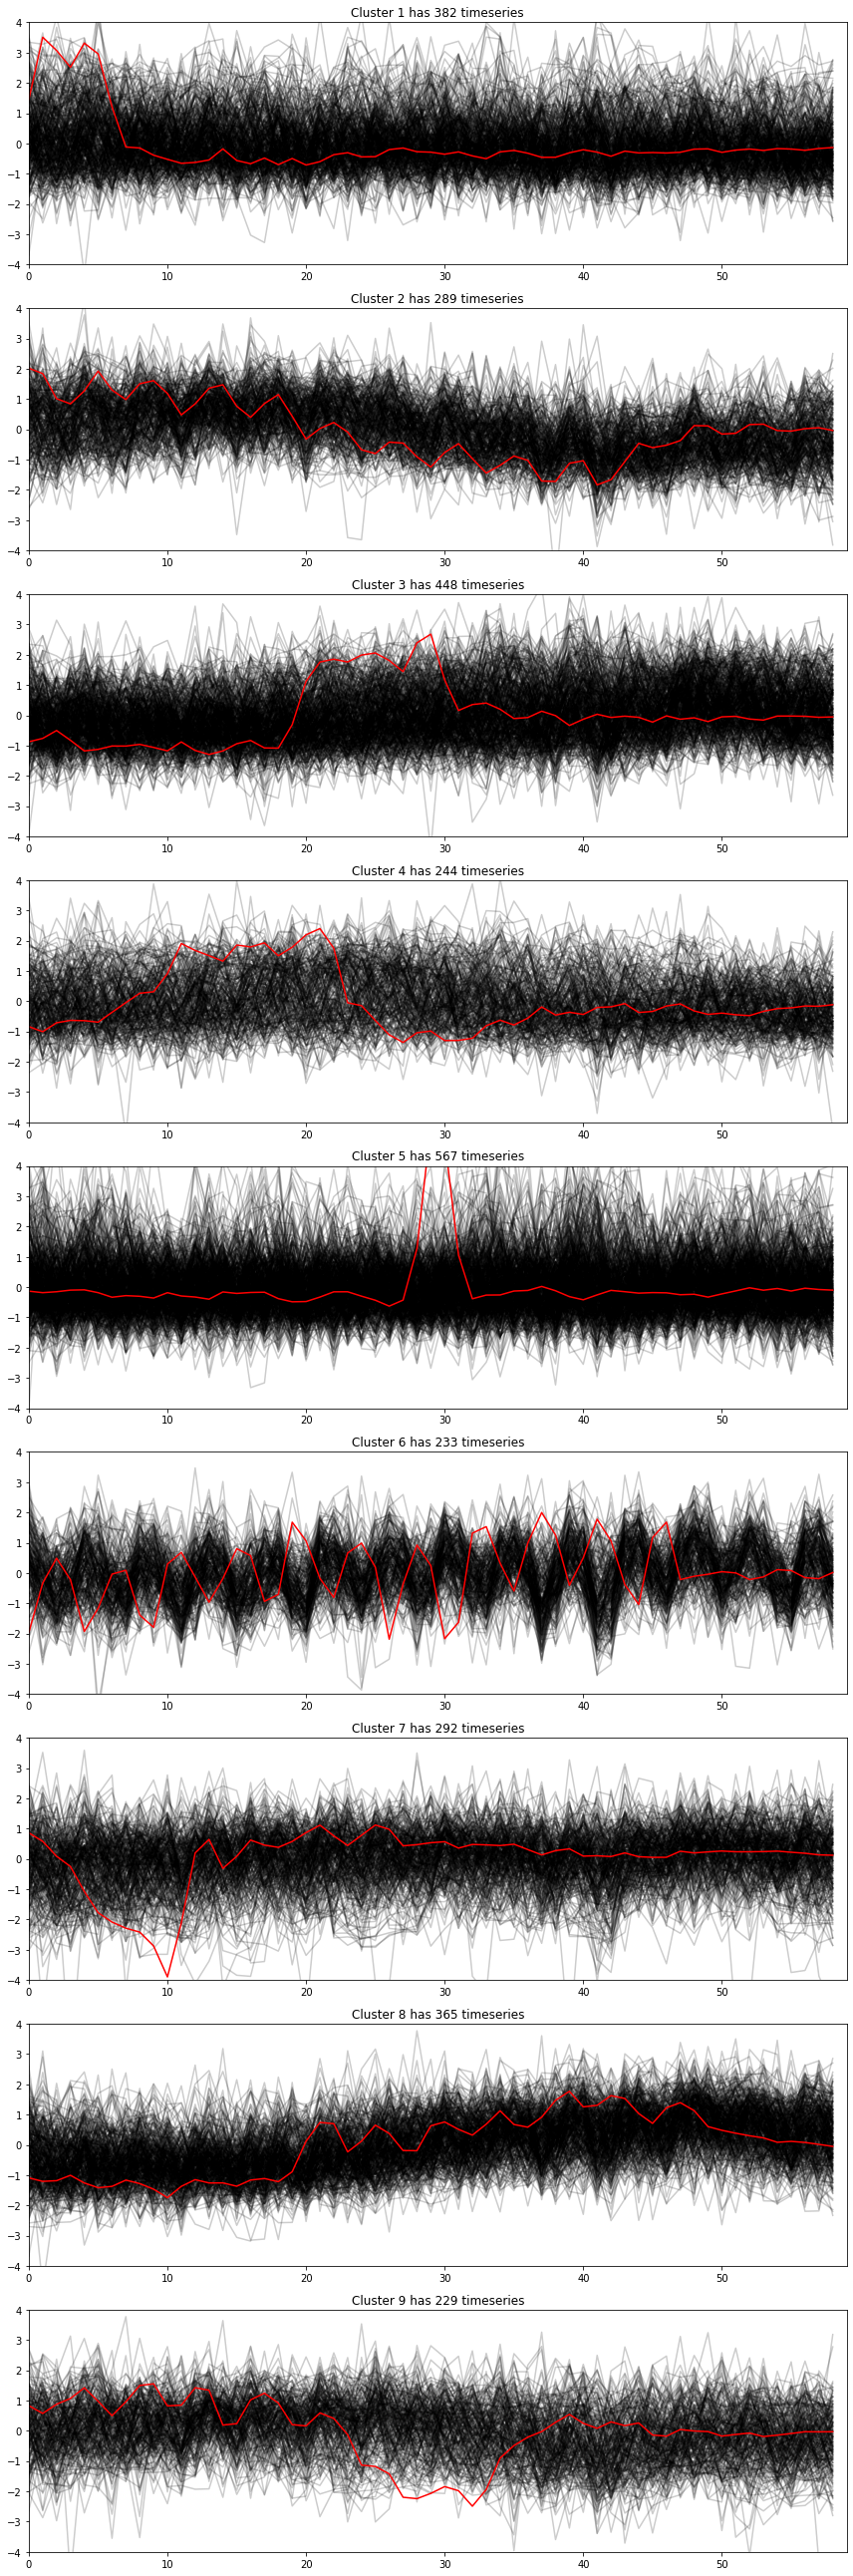

In [34]:
X_train = X_train.values

# For this method to operate properly, prior scaling is required
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
sz = X_train.shape[1]

# kShape clustering
ks = KShape(n_clusters=nc, verbose=True, random_state=seed)
y_pred = ks.fit_predict(X_train)

plt.figure(figsize=(12,nc*4))
for yi in range(nc):
    plt.subplot(nc, 1, 1 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title(f"Cluster {str(yi + 1)} has {str(X_train[y_pred == yi].shape[0])} timeseries") 

plt.tight_layout()
plt.show()

In [35]:
grid_df.id.nunique()

30490

In [36]:
clustter_df = pd.concat([pd.Series(item_ids), pd.Series(y_pred)],axis=1)
clustter_df.columns = ['item_id','clustter']

In [37]:
clustter_df.head(5)

,item_id,clustter
0,FOODS_1_001,5
1,FOODS_1_002,4
2,FOODS_1_003,2
3,FOODS_1_004,1
4,FOODS_1_005,4


In [38]:
clustter_df.clustter.value_counts()

4    567
2    448
0    382
7    365
6    292
1    289
3    244
5    233
8    229
Name: clustter, dtype: int64

In [39]:
grid_df.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,release,wm_yr_wk,gaps,gap_days,gap_e,sale_prob,stockout,sale_outlier,sales_clean,rolling_w7_l1_mean
0,HOUSEHOLD_1_514_WI_3_validation,HOUSEHOLD_1_514,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,902,16,11325,11325,0,0.0,0.000000e+00,0.011513,0,0,16.0,NaN
1,HOUSEHOLD_1_515_WI_3_validation,HOUSEHOLD_1_515,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,902,1,11325,11325,0,0.0,0.000000e+00,0.182983,0,0,1.0,NaN
2,HOUSEHOLD_1_516_WI_3_validation,HOUSEHOLD_1_516,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,902,1,11325,11325,0,0.0,0.000000e+00,0.080627,0,0,1.0,NaN
3,HOUSEHOLD_1_517_WI_3_validation,HOUSEHOLD_1_517,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,902,1,11325,11325,0,0.0,0.000000e+00,0.043671,0,0,1.0,NaN
6,HOUSEHOLD_1_520_WI_3_validation,HOUSEHOLD_1_520,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,902,1,11325,11325,0,40.0,1.168386e+24,0.217285,1,0,NaN,NaN


In [40]:
clustter_df.to_csv('clustter_df.csv', index=False)

In [ ]:
%%time
data.drop(['snap_CA','snap_TX','snap_WI','cum_day'],axis=1, inplace=True)

In [ ]:
%%time
store_df = data.groupby(['store_id', 'date_block_num']).\
                                       agg(store_mean_lag1=('demand', 'mean'),store_std_lag1=('demand', 'std'), store_skew_lag1=('demand','skew')).reset_index()

agg_cols = ["mean",'skew', 'std']


tmp_df = data[(data.date_block_num == 64 )&(data.day <= 24)].groupby(['store_id']).\
                agg(store_mean_lag1=('demand', 'mean'),store_std_lag1=('demand', 'std'), store_skew_lag1=('demand','skew')).reset_index()

store_df = reduce_mem_usage(store_df)

for i in tqdm_notebook(range(10)):
    store_df_temp = store_df[store_df.store_id == i].copy()
    for col in agg_cols:
        store_df_temp.loc[(store_df_temp.date_block_num == 64) & (store_df_temp.store_id == i), 'store_{}_lag1'.format(col)]\
                                                = tmp_df.loc[tmp_df.store_id ==i, 'store_{}_lag1'.format(col)].values
    store_df_temp.date_block_num += 2
    for col in agg_cols:
        dict_tmp = store_df_temp[['date_block_num', 'store_{}_lag1'.format(col)]].set_index('date_block_num').T.loc['store_{}_lag1'.format(col)]
        data.loc[data.store_id==i, 'store_{}_lag1'.format(col)] = data.date_block_num.map(dict_tmp)

for col in agg_cols:
    features.append('store_{}_lag1'.format(col))
    
del store_df, store_df_temp, dict_tmp, tmp_df
gc.collect()

In [ ]:
%%time
cat_df = data.groupby(['cat_id', 'date_block_num']).\
                    agg(cat_mean_lag1=('demand', 'mean'),cat_std_lag1=('demand', 'std'), cat_skew_lag1=('demand','skew')).reset_index()

tmp_df = data[(data.date_block_num == 64 )&(data.day <= 24)].groupby(['cat_id']).\
                agg(cat_mean_lag1=('demand', 'mean'),cat_std_lag1=('demand', 'std'), cat_skew_lag1=('demand','skew')).reset_index()

cat_df = reduce_mem_usage(cat_df)

for i in tqdm_notebook(range(3)):
    cat_df_temp = cat_df[cat_df.cat_id == i].copy()
    for col in agg_cols:
        cat_df_temp.loc[cat_df_temp.date_block_num == 64, 'cat_{}_lag1'.format(col)] = \
                                                                                            tmp_df.loc[tmp_df.cat_id==i,'cat_{}_lag1'.format(col)].values
    cat_df_temp.date_block_num += 2
    for col in agg_cols:
        dict_tmp = cat_df_temp[['date_block_num', 'cat_{}_lag1'.format(col)]].set_index('date_block_num').T.\
                            loc['cat_{}_lag1'.format(col)]
        data.loc[data.cat_id==i, 'cat_{}_lag1'.format(col)] = data.date_block_num.map(dict_tmp)
        

for col in agg_cols:
    features.append('cat_{}_lag1'.format(col))
        
del cat_df, cat_df_temp, dict_tmp, tmp_df
gc.collect()

In [ ]:
%%time
dow_df = data.groupby(['dayofweek', 'date_block_num']).\
                    agg(dow_mean_lag1=('demand', 'mean'),dow_std_lag1=('demand', 'std'),dow_skew_lag1=('demand','skew')).reset_index()

tmp_df = data[(data.date_block_num == 64 )&(data.day <= 24)].groupby(['dayofweek']).\
                agg(dow_mean_lag1=('demand', 'mean'),dow_std_lag1=('demand', 'std'), dow_skew_lag1=('demand','skew')).reset_index()

dow_df = reduce_mem_usage(dow_df)

for i in tqdm_notebook(range(7)):
    dow_df_temp = dow_df[dow_df.dayofweek == i].copy()
    for col in agg_cols:
        dow_df_temp.loc[dow_df_temp.date_block_num == 64, 'dow_{}_lag1'.format(col)] = \
                                                                                            tmp_df.loc[tmp_df.dayofweek==i,'cat_{}_lag1'.format(col)].values
    dow_df_temp.date_block_num += 2
    for col in agg_cols:
        dict_tmp = dow_df_temp[['date_block_num', 'dow_{}_lag1'.format(col)]].set_index('date_block_num').T.\
                            loc['dow_{}_lag1'.format(col)]
        data.loc[data.dayofweek==i, 'dow_{}_lag1'.format(col)] = data.date_block_num.map(dict_tmp)
        

for col in agg_cols:
    features.append('dow_{}_lag1'.format(col))
        
del dow_df, dow_df_temp, dict_tmp, tmp_df
gc.collect()

In [ ]:
%%time
dept_df = data.groupby(['dept_id', 'date_block_num']).\
                    agg(dept_mean_lag1=('demand', 'mean'),dept_std_lag1=('demand', 'std'),dept_skew_lag1=('demand','skew')).reset_index()

tmp_df = data[(data.date_block_num == 64 )&(data.day <= 24)].groupby(['dept_id']).\
                agg(dept_mean_lag1=('demand', 'mean'),dept_std_lag1=('demand', 'std'), dept_skew_lag1=('demand','skew')).reset_index()

dept_df = reduce_mem_usage(dept_df)

for i in tqdm_notebook(range(7)):
    dept_df_temp = dept_df[dow_df.dept == i].copy()
    for col in agg_cols:
        dept_df_temp.loc[dept_df_temp.date_block_num == 64, 'dept_{}_lag1'.format(col)] = \
                                                                                            tmp_df.loc[tmp_df.dept_id==i,'dept_{}_lag1'.format(col)].values
    dept_df_temp.date_block_num += 2
    for col in agg_cols:
        dict_tmp = dept_df_temp[['date_block_num', 'dept_{}_lag1'.format(col)]].set_index('date_block_num').T.\
                            loc['dept_{}_lag1'.format(col)]
        data.loc[data.dept_id==i, 'dept_{}_lag1'.format(col)] = data.date_block_num.map(dict_tmp)
        

for col in agg_cols:
    features.append('dept_{}_lag1'.format(col))
        
del dept_df, dept_df_temp, dict_tmp, tmp_df
gc.collect()

In [ ]:
data = data[data.date_block_num > 32]
data = reduce_mem_usage(data)

In [ ]:
data.info()

In [ ]:
data.describe()

In [ ]:
del calendar
gc.collect()

In [ ]:
del sales_train_validation
gc.collect()

In [ ]:
del sales_train_evaluation
gc.collect()

In [ ]:
#FEATURES to remove
## These features lead to overfit
## or values not present in test set
# remove_features = ['id','state_id','date']
# １. store_id, 3. state_idの順に消去して訓練し直す。
# features = [col for col in features if col not in remove_features]

In [ ]:
data_columns = [col for col in features if "demand" not in col]



def run_lgb(data):
    
    # going to evaluate with the last 28 days
    x_train = data[data['date'] <= '2016-03-27']
    y_train = x_train['demand']
    x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
    y_val = x_val['demand']
    test = data[(data['date'] > '2016-04-24')]
    del data
    gc.collect()

    # define random hyperparammeters
    params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'objective': 'regression',
        'n_jobs': -1,
        'seed': 236,
        'learning_rate': 0.1,
        'bagging_fraction': 0.75,
        'bagging_freq': 10, 
        'colsample_bytree': 0.75
    }
    

    lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 1400,
                    'boost_from_average': False,
                    'verbose': -1,
    } 


    
    X_train_np = x_train[features].values.astype(np.float16)
    X_valid_np = x_val[features].values.astype(np.float16)
    test_np = test[features].values.astype(np.float16)
    del x_train, x_val
    gc.collect()

    train_set = lgb.Dataset(X_train_np, label = y_train, feature_name = features)
    val_set = lgb.Dataset(X_valid_np, label = y_val, feature_name = features)
    
    del X_train_np
    gc.collect()

    model = lgb.train(lgb_params, train_set, num_boost_round = 2500, early_stopping_rounds = 100, valid_sets = [train_set, val_set], verbose_eval = 100)
    val_pred = model.predict(X_valid_np)
    # sorted(zip(clf.feature_importances_, X.columns), reverse=True)
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),data_columns)), columns=['Value','Feature'])

    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
#     title = "lgbm_importances_model_" + str(i) + ".png"
#     plt.savefig(title)

    val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
    print(f'Our val rmse score is {val_score}')
    del X_valid_np
    gc.collect()
    y_pred = model.predict(test_np)
    test['demand'] = y_pred
    return test

def predict(test, submission):
    predictions = test[['id', 'date', 'demand']]
    predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
    predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

    evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
    evaluation = submission[submission['id'].isin(evaluation_rows)]

    validation = submission[['id']].merge(predictions, on = 'id')
    final = pd.concat([validation, evaluation])
    final.to_csv('submission.csv', index = False)
    return final


In [ ]:
data.drop(["part",'release'],axis=1, inplace=True)
gc.collect()



# for i in range(3):
#     state_df = data[data.state_id == i]
#     test_df = run_lgb(state_df)
#     if i == 0:
#         test = test_df 
#     else:
#         test = pd.concat([test, test_df])

test = run_lgb(data)
final = predict(test, submission)

In [ ]:
# predict(test,submission)

In [ ]:
data[features].head(5)

In [ ]:
features

In [ ]:
data.head(5)

In [ ]:
from typing import Union

class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 0  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'cat_id',
            'state_id',
            'dept_id',
            'store_id',
            'item_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm_notebook(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]):
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        group_ids = []
        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            group_ids.append(group_id)
            all_scores.append(lv_scores.sum())

        return group_ids, all_scores

In [ ]:
ls ../

In [ ]:
ls ../input/

In [ ]:
## reading data
df_calendar = pd.read_csv("../input/calendar.csv")
df_prices = pd.read_csv("../input/sell_prices.csv")
df_sample_submission = pd.read_csv("../input/sample_submission.csv")
df_sample_submission["order"] = range(df_sample_submission.shape[0])

df_train_full = pd.read_csv("../input/sales_train_evaluation.csv")



df_train = df_train_full.iloc[:, :-28]
df_valid = df_train_full.iloc[:, -28:]

evaluator = WRMSSEEvaluator(df_train, df_valid, df_calendar, df_prices)

In [ ]:
## evaluating random submission
groups, scores = evaluator.score(final)

score_public_lb = np.mean(scores)
# score_public_rank = get_lb_rank(score_public_lb)

for i in range(len(groups)):
    print(f"Score for group {groups[i]}: {round(scores[i], 5)}")

print(f"\nPublic LB Score: {round(score_public_lb, 5)}")